### Import Libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding
from keras.utils import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [4]:
from IPython.display import clear_output
import nltk
nltk.download("all")
clear_output()

### Load Data

In [5]:
df_article = pd.read_csv('https://raw.githubusercontent.com/algonacci/Data-Warehouse/main/data-newspaper.csv')
df_article.head()

,article_id,article_topic,article_content
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har..."
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma..."


In [6]:
df_article.tail()

,article_id,article_topic,article_content
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj..."
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...
9999,93194682,Teknologi,Telkom masih melakukan proses perbaikan dan p...


### Exploratory Data Analysis

In [7]:
df_article['article_topic'].unique()

array(['Internasional', 'Ekonomi', 'Teknologi', 'Hiburan', 'Haji',
       'Travel', 'Personal', 'Sepak Bola', 'Health', 'Sports', 'Politik',
       'Otomotif', 'KPK', 'Lifestyle', 'Keuangan', 'Sejarah', 'Regional',
       'Pendidikan', 'Hukum', 'Obat-obatan', 'Bojonegoro', 'Kesehatan',
       'Horor', 'Bisnis', 'MotoGP', 'Sains', 'Jakarta', 'Pilgub Jatim',
       'K-Pop'], dtype=object)

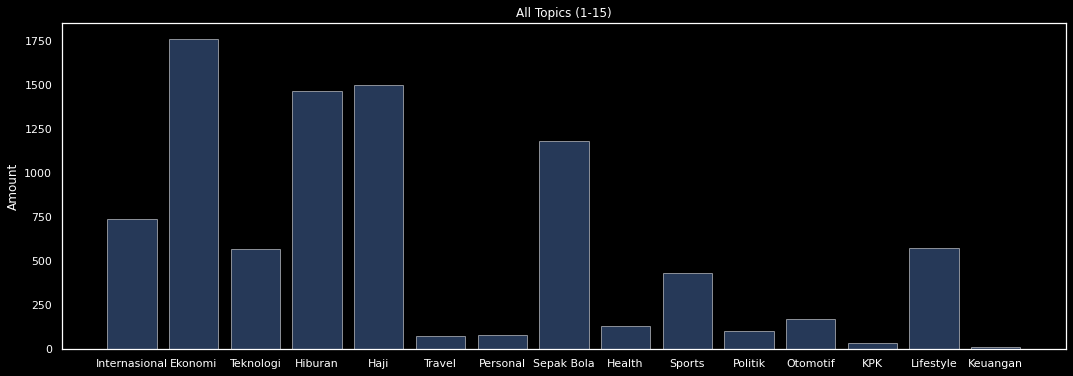

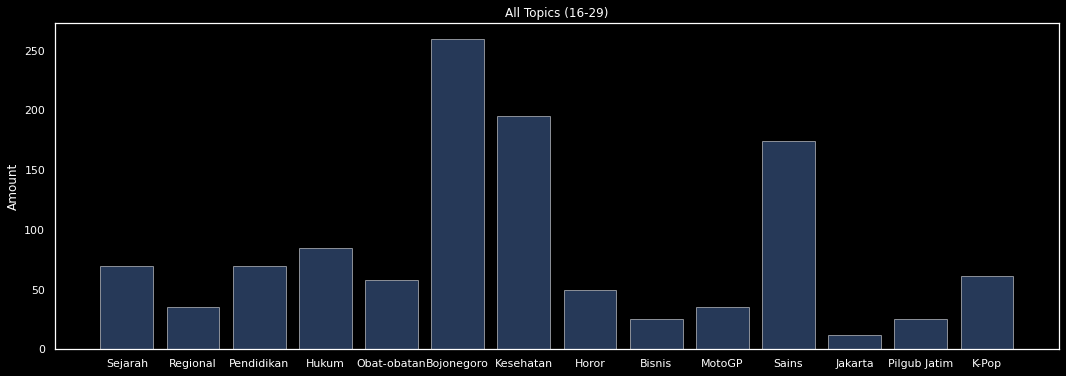

In [8]:
objects = df_article['article_topic'].unique()
y_pos = np.arange(len(objects))
performance = [len(df_article[df_article['article_topic'] == topic]) for topic in df_article['article_topic'].unique()]

plt.figure(figsize=(18,6))
plt.bar(y_pos[:15], performance[:15], align='center', alpha=0.5)
plt.xticks(y_pos[:15], objects[:15])
plt.ylabel('Amount')
plt.title('All Topics (1-15)')
plt.grid()
plt.show()

plt.figure(figsize=(18,6))
plt.bar(y_pos[15:], performance[15:], align='center', alpha=0.5)
plt.xticks(y_pos[15:], objects[15:])
plt.ylabel('Amount')
plt.title('All Topics (16-29)')
plt.grid()
plt.show()

In [9]:
df_article['article_content'][0]

' Kepolisian Inggris tengah memburu pelaku yang meledakkan bom di stasiun London. Sedikitnya 22 orang terluka dalam peristiwa yang terjadi pada Jumat pagi yang sibuk (15/9).Menurut asisten komisaris kepolisian Inggris Mark Rowley seperti dikutip The Guardian, ratusan detektif dikerahkan untuk menyelidiki kasus ini. Mereka akan memeriksa semua rekaman CCTV di jaringan kereta bawah tanah London untuk mencari pelakunya.Sebelumnya kepolisian telah menangani kasus ini sebagai aksi terorisme. Penyelidikan juga dilakukan oleh Komando Pemberantasan Terorisme Kepolisian London dan badan keamanan dalam negeri Inggris MI5.Ledakan terjadi di stasiun Parsons Green di salam satu gerbong kereta. Peristiwa ini memicu kepanikan ratusan penumpang yang langsung berhamburan menyelamatkan diri. Sedikitnya 22 orang terluka, namun tidak mengancam nyawa.Menurut kepolisian, bom rakitan itu belum sepenuhnya meledak. Tim forensik akan menyelidiki bom itu, mencari tahu bahan kimia yang digunakan, dan dari mana pe

### Text Processing

In [10]:
total_null = df_article['article_content'].isnull().sum()
print('Total null: {}'.format(total_null))

Total null: 36


In [11]:
df_article = df_article.dropna(how='any')
df_article = df_article.reset_index()
df_article.tail()

,index,article_id,article_topic,article_content
9959,9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...
9960,9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj..."
9961,9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...
9962,9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...
9963,9999,93194682,Teknologi,Telkom masih melakukan proses perbaikan dan p...


In [12]:
all_texts = df_article['article_content'].to_numpy()
all_texts

array([' Kepolisian Inggris tengah memburu pelaku yang meledakkan bom di stasiun London. Sedikitnya 22 orang terluka dalam peristiwa yang terjadi pada Jumat pagi yang sibuk (15/9).Menurut asisten komisaris kepolisian Inggris Mark Rowley seperti dikutip The Guardian, ratusan detektif dikerahkan untuk menyelidiki kasus ini. Mereka akan memeriksa semua rekaman CCTV di jaringan kereta bawah tanah London untuk mencari pelakunya.Sebelumnya kepolisian telah menangani kasus ini sebagai aksi terorisme. Penyelidikan juga dilakukan oleh Komando Pemberantasan Terorisme Kepolisian London dan badan keamanan dalam negeri Inggris MI5.Ledakan terjadi di stasiun Parsons Green di salam satu gerbong kereta. Peristiwa ini memicu kepanikan ratusan penumpang yang langsung berhamburan menyelamatkan diri. Sedikitnya 22 orang terluka, namun tidak mengancam nyawa.Menurut kepolisian, bom rakitan itu belum sepenuhnya meledak. Tim forensik akan menyelidiki bom itu, mencari tahu bahan kimia yang digunakan, dan dari 

In [13]:
stop_words = set(stopwords.words('indonesian'))

In [14]:
def clean(text):
  text = text.lower()
  # Removing html tags
  text = re.sub('[^>]*>', '',text)
  # Removing emails
  text = re.sub('\S*@\S\s?', '', text)
  # Removing urls
  text = re.sub('http?://[A-Za-z0-9]', '', text)
  # Removing numbers
  text = re.sub('[^a-zA-Z]', ' ', text)
  word_tokens = word_tokenize(text)
  filtered_sentence = []
  for word_token in word_tokens:
    if word_token not in stop_words:
      filtered_sentence.append(word_token)

  # Joining words
  text = (' '.join(filtered_sentence))
  return text

In [15]:
all_cleaned_texts = np.array([clean(text) for text in all_texts])

In [16]:
all_cleaned_texts

array(['kepolisian inggris memburu pelaku meledakkan bom stasiun london orang terluka peristiwa jumat pagi sibuk asisten komisaris kepolisian inggris mark rowley dikutip the guardian ratusan detektif dikerahkan menyelidiki memeriksa rekaman cctv jaringan kereta tanah london mencari pelakunya kepolisian menangani aksi terorisme penyelidikan komando pemberantasan terorisme kepolisian london badan keamanan negeri inggris mi ledakan stasiun parsons green salam gerbong kereta peristiwa memicu kepanikan ratusan penumpang langsung berhamburan menyelamatkan orang terluka mengancam nyawa kepolisian bom rakitan sepenuhnya meledak tim forensik menyelidiki bom mencari bahan kimia pelaku mempelajari pembuatannya inggris mengalami kali serangan teroris menewaskan orang orang tewas ledakan bunuh kereta tanah london bus',
       'layanan transaksi jalan tol sistem nontunai oktober meningkatkan layanan kebijakan diterapkan transaksi gerbang tol efisien antrean kendaraan deputi gubernur bank indonesia b

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

In [18]:
all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

In [19]:
for i in range(5):
  print('Length of file', i, ':', len(all_encoded_texts[i]))

Length of file 0 : 100
Length of file 1 : 211
Length of file 2 : 80
Length of file 3 : 177
Length of file 4 : 180


In [20]:
all_encoded_texts = pad_sequences(all_encoded_texts, maxlen=500)
all_encoded_texts

array([[    0,     0,     0, ...,    70,  1292,   224],
       [    0,     0,     0, ...,  2155,   567,  9669],
       [    0,     0,     0, ...,    37,  4322, 16587],
       ...,
       [    0,     0,     0, ...,     6,  2238,  2238],
       [    0,     0,     0, ...,   891,  2476,   820],
       [    0,     0,     0, ...,  2203, 15805,   194]], dtype=int32)

### Label Processing

In [21]:
total_labels = len(df_article['article_topic'].unique())
print('Total labels:', total_labels)

Total labels: 29


In [22]:
all_labels = np.array(df_article['article_topic'])

In [23]:
all_labels = all_labels[:, np.newaxis]

In [24]:
all_labels

array([['Internasional'],
       ['Ekonomi'],
       ['Teknologi'],
       ...,
       ['Sepak Bola'],
       ['Sepak Bola'],
       ['Teknologi']], dtype=object)

In [25]:
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels)

In [26]:
all_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Model Training

In [27]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, all_labels, test_size=0.2,
                                                    random_state=24, stratify=all_labels)

In [28]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=500))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_labels, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=20, batch_size=54, validation_data=(X_test, y_test))

Epoch 1/20
148/148 [==============================] - 17s 59ms/step - loss: 2.2565 - accuracy: 0.3592 - val_loss: 1.6458 - val_accuracy: 0.5790
Epoch 2/20
148/148 [==============================] - 8s 53ms/step - loss: 1.3880 - accuracy: 0.6086 - val_loss: 1.2809 - val_accuracy: 0.6232
Epoch 3/20
148/148 [==============================] - 8s 55ms/step - loss: 0.9697 - accuracy: 0.7306 - val_loss: 1.2224 - val_accuracy: 0.6623
Epoch 4/20
148/148 [==============================] - 8s 52ms/step - loss: 0.7274 - accuracy: 0.7945 - val_loss: 0.8964 - val_accuracy: 0.7476
Epoch 5/20
148/148 [==============================] - 8s 53ms/step - loss: 0.4997 - accuracy: 0.8547 - val_loss: 0.8421 - val_accuracy: 0.7662
Epoch 6/20
148/148 [==============================] - 8s 52ms/step - loss: 0.5841 - accuracy: 0.8333 - val_loss: 0.8917 - val_accuracy: 0.7602
Epoch 7/20
148/148 [==============================] - 8s 53ms/step - loss: 0.3351 - accuracy: 0.9103 - val_loss: 0.8440 - val_accuracy: 0.785

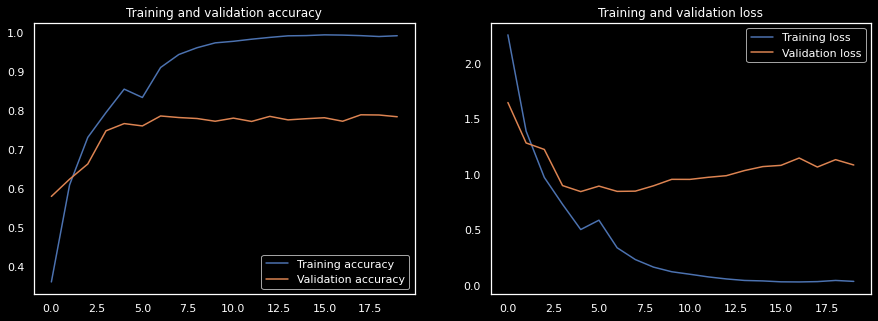

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
plt.grid(visible=None)
ax2 = fig.add_subplot(1,2,2)
plt.grid(visible=None)

ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)

ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

plt.savefig("plot.png")

In [46]:
model.save('model.h5')

### Model Evaluation

In [47]:
predictions = model.predict(X_test)
predictions_evaluate = np.argmax(predictions, axis=1)

63/63 [==============================] - 2s 17ms/step


In [48]:
y_test_evaluate = np.argmax(y_test, axis=1)

In [49]:
target_names = [target_name.split('_')[1] for target_name in one_hot_encoder.get_feature_names()]
print(classification_report(y_test_evaluate, predictions_evaluate, target_names=target_names))

print('Total Weighted F1 Score:', f1_score(y_test_evaluate, predictions_evaluate, average='weighted'))

               precision    recall  f1-score   support

       Bisnis       0.10      0.20      0.13         5
   Bojonegoro       1.00      0.96      0.98        52
      Ekonomi       0.93      0.90      0.91       352
         Haji       0.99      0.98      0.99       299
       Health       0.52      0.46      0.49        26
      Hiburan       0.81      0.88      0.84       290
        Horor       0.00      0.00      0.00        10
        Hukum       0.33      0.47      0.39        17
Internasional       0.77      0.72      0.74       148
      Jakarta       0.00      0.00      0.00         2
        K-Pop       1.00      0.50      0.67        12
          KPK       1.00      0.57      0.73         7
    Kesehatan       0.57      0.64      0.60        39
     Keuangan       0.00      0.00      0.00         3
    Lifestyle       0.72      0.73      0.72       114
       MotoGP       0.00      0.00      0.00         7
  Obat-obatan       0.62      0.67      0.64        12
     Otom

### Test

In [90]:
string = 'Kepolisian Inggris tengah memburu pelaku yang meledakkan bom di stasiun London'

In [91]:
cleaned_string = clean(string)
encoded_string = tokenizer.texts_to_sequences([cleaned_string])
encoded_string = pad_sequences(encoded_string, maxlen=500)

In [92]:
string_predict = model.predict(encoded_string)
print(str(one_hot_encoder.inverse_transform(string_predict).item()))

1/1 [==============================] - 0s 43ms/step
Kesehatan


### Word2Vec

In [93]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(83678, 64)


In [94]:
reverse_word_index = tokenizer.index_word

In [95]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, 500):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [98]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

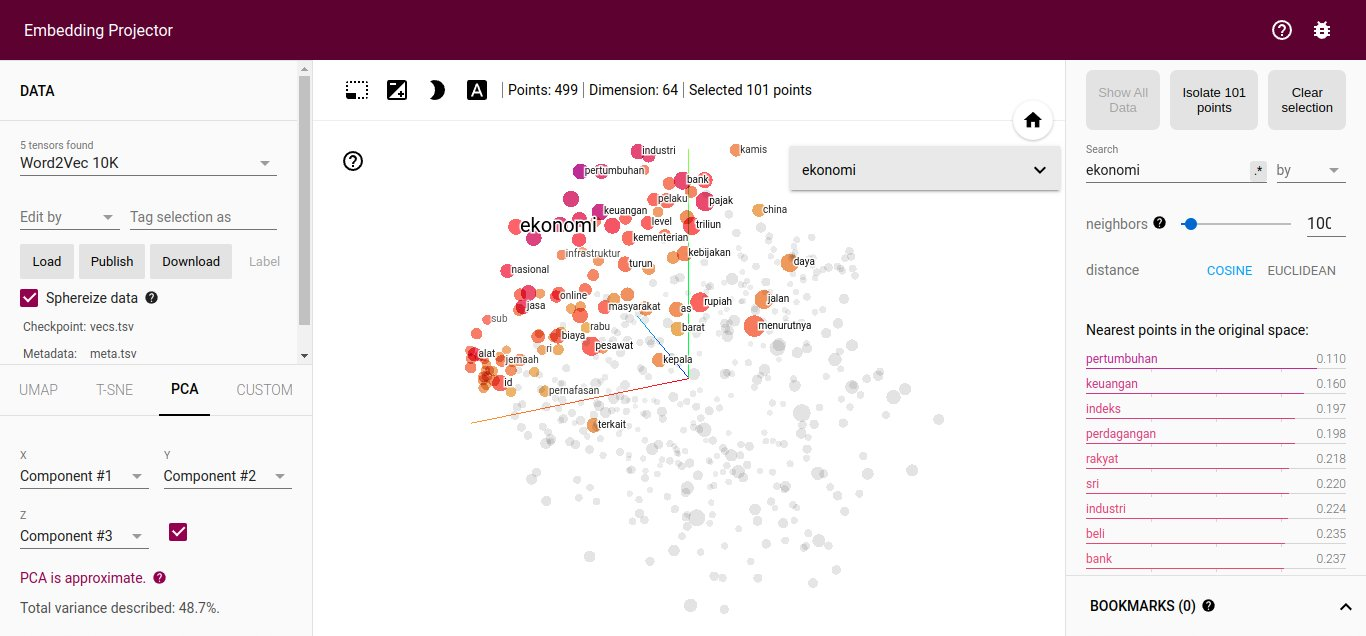